# End-to-end Multi-class Dog Breed Classification

This notebook builds an en-to-end multic-class image classifier using TensorFlow 2.0 and TensorFlow hub.


## 1.Problem

Identifying the breed of a dog given an image of a dog.
When I'm sitting at the cafe and I take a phoro of a dog, I want to know what breed of  dog it is

## 2.Data
The data  we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data?select=train


## 3.Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4.Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs(this means there are 120 different classes).
* There are around 10,000+ images in the training set
(these images have labels)
* There are around 10,000+ images in the test set
(these images have not labels, because we'll want to predict them).

### Get our workspace ready
* import TensorFlow 2.x
* import tensorflow hub
* Make sure're using a gpu

In [5]:
# Import TensorFLow
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF_Hub version", hub.__version__)

# Check for GPU availability
print("GPU","available(YESSSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :")

TF version: 2.4.1
TF_Hub version 0.11.0
GPU not available :


## Getting our data ready(turning into Tensors)
With all machine learning model, our data has to be in numerical format.  So
that's what we'll be doing first. Turning our images into Tensors (numerical representations)

Let's start by accessing our data and checking out the labels.

In [6]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     720ee45bf7ba0344983a5a7b6ab4cd6c  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


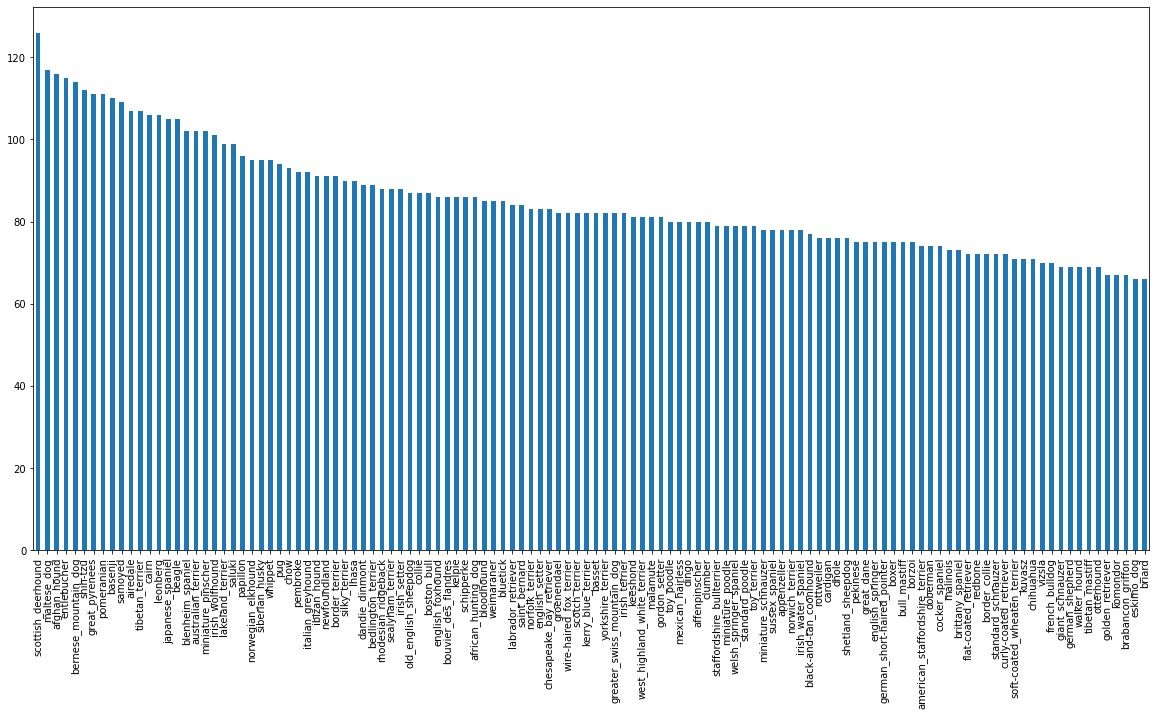

In [11]:
# How many images are there of each breeds?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [13]:
# promedio de imagenes por clases
labels_csv["breed"].value_counts().median()

82.0

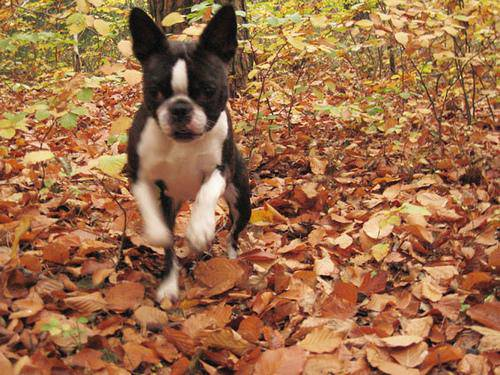

In [15]:
# Let's view an image
from IPython.display import Image
Image("dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames.


In [16]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [20]:
# Create pathnames from images ID's, comprehension of list
# crea una lista de f nombres para todos elementos en la colunma "id"
mainpaht = "dog-breed-identification/train/"
filenames = [mainpaht + fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [21]:
# Check whether number of filenames matches number of actual image files
import os 
if len(os.listdir("dog-breed-identification/train/")) == len(filenames):
    print("Filesnames match actual amount of files Proceed.!!!")
else:
    print("Filenames not match actual amount of files, check the target directory")

Filesnames match actual amount of files Proceed.!!!


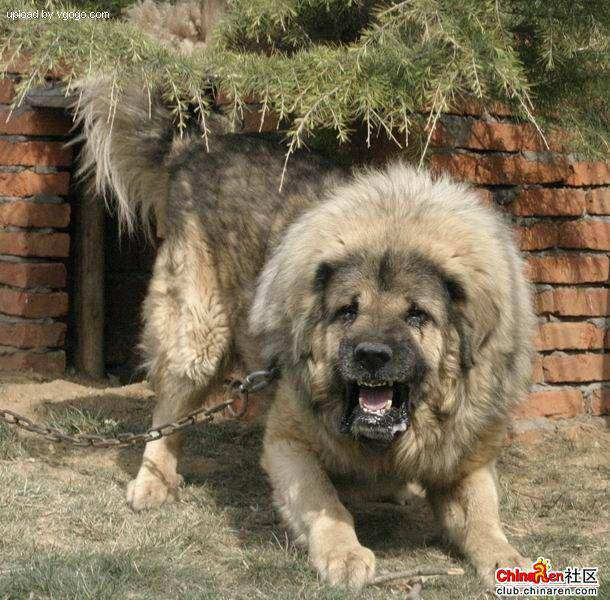

In [22]:
# con  esto ya tenemos todos los nombres en una lista y tenemos la misma cantidad de id que de imagenes
# One more check

Image(filenames[9000])

In [24]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list,
Let's prepare our labels

In [29]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# lo convertimos en un array # hace lo mismo que arriba
#labels = np.array(labels) 
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [30]:
len(labels)

10222

In [31]:
# See if number of labels matches the number of filenames(filespath)
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number of labels does not match number of filenames, check data directories!")
    


Number of labels matches number of filenames


In [33]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [34]:
# Turn a single label into an array of booleans
print(labels[0])
# esto me retornara una array de trues and false
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [37]:
len(labels)

10222

In [35]:
# Turn every label into a boolean array
# otra lista comprimida haremos lo mismo que arriba para cada elemento
boolean_labels =[label ==  unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [36]:
len(boolean_labels)

10222

In [38]:
# Example: Turning boolean array into integers
print(labels[0])# original label

print(np.where(unique_breeds == labels[0] )) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int))#  there will be a 1 where the sample label occurs


boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [39]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [40]:
filenames[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [41]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set
Since the dataset  from Kaggle doesn't come with a validation set, we're going to create our own

In [42]:
# Setup x &  y variables

X = filenames

y = boolean_labels

We're going to start off experimenting with- 1000 images and increase as needed.

lo mismo se  aplica a muestras que no sean imagenes

In [43]:
# Siempre recordar que nuestra meta es minimizar el tiempo entre experimentos
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param { type:"slider", min:1000, max:10000, step: 1000}

In [45]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size = 0.2,
                                                   random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [46]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing images ( turning images into Tensor)

To preprocess our images into Tensors we're going to write a function
which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable,`image`
3. Turn our `image`(a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modfied `image`

Before we do, let's see what importing  an image looks like.
    

In [47]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image =imread(filenames[42])
image.shape
# alto, ancho, canales de colores

(257, 350, 3)

In [50]:
image.max(), image.min()

(255, 0)

In [52]:
# para convertir en tensor usamos
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function
to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable,`image`
3. Turn our `image`(a jpg) into Tensors
4. Normalize our image(convet color channel values from 0-255 to 0-1)
4. Resize the `image` to be a shape of (224, 224)
5. Return the modfied `image`

In [102]:
# Define image size
IMG_SIZE =224
# Create a function for preprocessing_images
def process_image(image_path, img_size =IMG_SIZE):
    """
    Takes an image file path and turns tje image into a tensor
    
    
    """
    
    # Read in a image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels(Read, Green, BLue)
    image = tf.image.decode_jpeg(image, channels =3 )
    # Convert the colour channel values from 0-255 to 0-1 values
    # normalizamos los valores esto permite que la computadora calcule mas eficiente
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image to our desired value(224, 224)
    
    image = tf.image.resize(image, size =[IMG_SIZE, IMG_SIZE])
    
    return image
    

In [55]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [56]:
tf.image.decode_jpeg(tensor, channels = 3)

<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[ 59,  68,  65],
        [ 64,  73,  70],
        [ 71,  80,  77],
        ...,
        [115, 128, 108],
        [115, 128, 108],
        [110, 123, 103]],

       [[ 65,  74,  71],
        [ 72,  81,  78],
        [ 79,  88,  85],
        ...,
        [114, 127, 107],
        [117, 130, 110],
        [116, 129, 109]],

       [[ 68,  77,  74],
        [ 76,  85,  82],
        [ 83,  92,  89],
        ...,
        [114, 127, 107],
        [120, 133, 113],
        [123, 136, 116]],

       ...,

       [[173, 200, 155],
        [164, 179, 136],
        [181, 166, 133],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[142, 159, 117],
        [147, 154, 113],
        [189, 174, 141],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[167, 179, 139],
        [167, 172, 132],
        [204, 188, 155],
        ...,
        [255, 255, 25

In [58]:

tensor =tf.image.convert_image_dtype(image, tf.float32)
tensor

<tf.Tensor: shape=(257, 350, 3), dtype=float32, numpy=
array([[[0.34901962, 0.5372549 , 0.34117648],
        [0.29803923, 0.48627454, 0.2901961 ],
        [0.24705884, 0.43529415, 0.23137257],
        ...,
        [0.29803923, 0.5254902 , 0.3372549 ],
        [0.29803923, 0.5254902 , 0.3372549 ],
        [0.29803923, 0.5254902 , 0.3372549 ]],

       [[0.28235295, 0.4666667 , 0.28627452],
        [0.2627451 , 0.44705886, 0.26666668],
        [0.24705884, 0.43529415, 0.24705884],
        ...,
        [0.29411766, 0.5137255 , 0.32941177],
        [0.2901961 , 0.5176471 , 0.32941177],
        [0.2901961 , 0.5137255 , 0.3372549 ]],

       [[0.21960786, 0.40784317, 0.25882354],
        [0.227451  , 0.4156863 , 0.25882354],
        [0.2509804 , 0.43921572, 0.28235295],
        ...,
        [0.2784314 , 0.49803925, 0.32156864],
        [0.28627452, 0.5058824 , 0.32941177],
        [0.28627452, 0.50980395, 0.33333334]],

       ...,

       [[0.00784314, 0.04313726, 0.03921569],
        [0.01

## Turning our data into batches
Why turn our data into batches?
Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

so that's why we do about 32(this is the batch size) images at a time(you can manually adjust the batch size if need be

In order to use TensorFlow effectively, we need our dara in the form of Tensor
tuples which look like this:
`(image, label)`
    

In [60]:
# Create a simple function to return a tuple(image, label)

def get_image_label(image_path, label):
    
    """
    Takes an image file path name and the associated label,
    
    processes the image returns a tuple of (image, label).
    """
    
    image  = process_image(image_path)
    
    return image, label
    

In [64]:
#Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors
in the form:`(image, label)`, let's make a function to turn all of our data(`X`&`y`
) into batches!

In [104]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches

def create_data_batches(X, y= None, batch_size = BATCH_SIZE, valid_data = False, test_data= False ):
    """
    Crete batches of data out of image (X) and label(y) pairs.
    
    Shuffles the data if it's training data, but doesn't shuffle if it's  validation data.
    
    
    
    
    """

    # If the data is a test dataset, we probably don't have labels
    
    if test_data:
        print("Creating test data batches....")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))# only filepaths (no labels)
        
        
        # map puede entenderse como aplica la funcion a los lotes  de la data
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        
        return data_batch
        
    # If the data is a valid dataset ,we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y)))   # labels
                                                   
                                               
                                             
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        
        return data_batch
    
    else:
        print("Creating training data batches....")
        
        # Turn filepaths and labels into Tensor
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        
        
        # Shuffling pathnames and labels before mapping images processor function is faster than shuffling images
        
        # buffer_size, cuantas variables quieres shuffle
        data = data.shuffle(buffer_size=len(X))
        
        # el shuffle es mejor hacerlo antes para que no tarde tanto
        # Create(image, label) tuples ( this also turns the image path into a preprocessed image )
        data = data.map(get_image_label)
        
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        
    return data_batch
        
    
    

In [105]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data =True)

Creating training data batches....
Creating validation data batches...


In [68]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec
# el none es por que el batch tiene que ser flexible

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [69]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Visualizing Data Batches
Our data is now in batches, however, these can be a little hard to understand/ comprehend, let's visualize them:

In [79]:
import matplotlib.pyplot as plt
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and labels from a data batch.
    
    
    
    """
    
    # Setup the figure
    plt.figure(figsize=(10, 10))
    
    # Loop tnrough 25 ( for displaying 25 images())
    for i in range(25):
        # Create subplots ( 5 rows, 5 columns)
        ax = plt.subplot(5,5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        
        # Turn the grid lines off
        plt.axis("off")
    


In [80]:
unique_breeds[y[0].argmax()]


'boston_bull'

In [81]:
train_data
# Necesitamos convertirlo en un iterador para poder recorrerlo y pintarlo

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [82]:
# me  regresa el bacht que no ees el primero
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images),len( train_labels)

(32, 32)

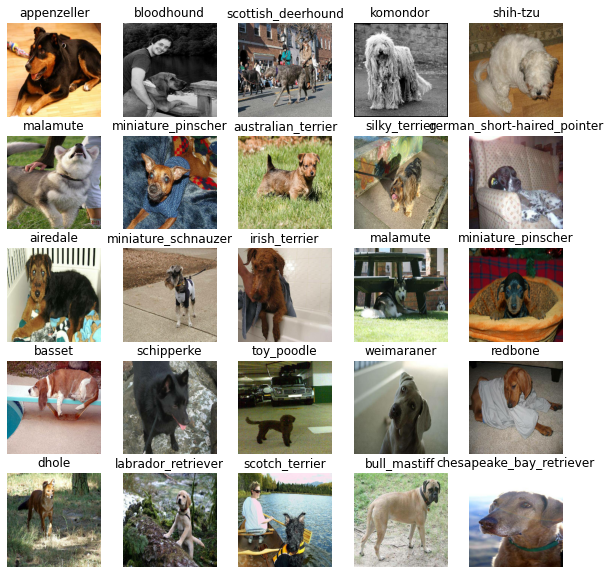

In [83]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

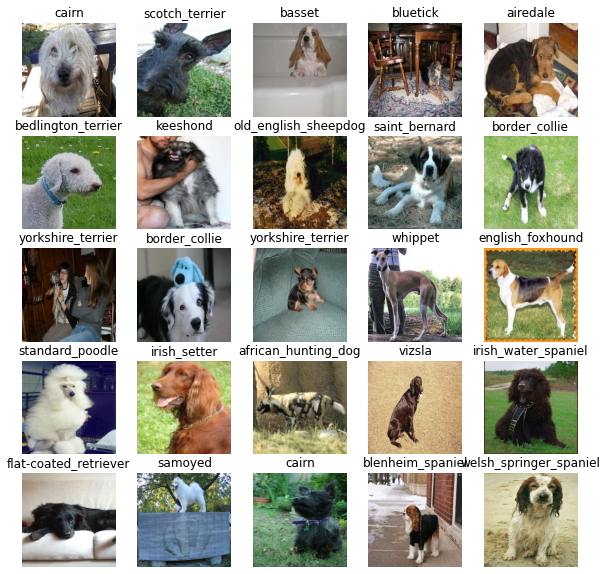

In [84]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())

show_25_images(val_images, val_labels)

In [85]:
# nota el bacht esta conformado por una lista de tuplas. tensor de tuplas, imagen, etiqueta



## Building a model

Before we  build a model, there a few things we need to define:
* The input shape(our images shape, in the form of tensors) to our model.
* The output shape( image labels, in the form of Tensors)of our model.
* The URL of the model we want to use from tensorflowhub
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [87]:
IMG_SIZE


224

In [106]:
# Setup input shape to the model
INPUT_SHAPE = [ None, IMG_SIZE, IMG_SIZE, 3]# batch, height, width, colour channels

# Setup output shape of our model
# cuantas categorias hay
OUTPUT_SHAPE = len(unique_breeds)
# Setup model URL from TensorFloe hub

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model.


Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.

* Defines the layers in a keras model in sequential fashion
(do this first, then this, then that). paso a paso

* Compiles the model( says it should be evaluated and improved).
* Builds the model( tells the model the input shape it'll be getting).
* Return the model.

All of these steps can be found here:
https://www.tensorflow.org/guide/keras/sequential_model


In [108]:
# Create a function which builds a Keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)
    
    # Setup the model layers
    model = tf.keras.Sequential([
        
        hub.KerasLayer(MODEL_URL),# layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation="softmax")# layer 2(output layer)
        
    ])
    
    # Compile the model
    model.compile(
        
        
        # nuesto modelo esta en una competencia internacional de bajar colina, y esta ciego
        # loss es la altura de la colina, la meta del modelo es minimizar la altura
        # llegar a lo mas bajo de la colina, el loss es una medida de cuanto el modelo mejora
        # mientras mas grande la perdida peor es la prediction, mienstas ma peque;a mejor
        
        loss=tf.keras.losses.CategoricalCrossentropy(),
        # el optimizador es nuestro amigo que nos grita desde abajo de colina como llegar
        # nos dice como navegar la colina, disminuir la  funcion de perdidas
        # nos dice que tan alto estamos en la monta;an, basa sus intrucciones en como nos hemos ido moviendo
        optimizer =  tf.keras.optimizers.Adam(),
        
        # esto nos dice el juicio que tan bien, que tan cerca estuvimos del fondo de la colina
        # que tan bien predecimos imagenes
        metrics=["accuracy"]
        
    
    
    
    )
    
    # Build the model
    # el tama;o de la imagen depende del modelo que queramos usar
    model.build(INPUT_SHAPE)
    
    return model
    
    
    
    


In [109]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [110]:
outputs = np.ones(shape=(1, 1, 1280))



In [111]:
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

# Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save ist progress, chek its progress or stop training
early if a model stops improving

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training far too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard extension
2. Create  a TensorBoard callback  which is able to save logs to a directory and pass it to our model's fit() function.
3. Visualize our models training logs with the `%tensorboard magic function` (we'll do this after model training).


In [112]:
%load_ext tensorboard

In [119]:
import datetime
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("dog-breed-identification/logs/",
                          # Make it so the logs get tracked whenever we run as experiment
                          datetime.datetime.now().strftime("Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)


### Early Stopping  Callback

Early stopping helps stop our model from overfitting  by stopping training

if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [114]:
# Create early stopping callback
# patiencie es el numero de epochs(epoca, iteraciones, cantidad de veces que pasamos la data por el modelo, estudiamos) que permite sin que se produscan mejoras en la exactitud/efectividad/accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                  patience =3)

## Training a model( on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.
buscamos minimizar el tiempo entre experimentos

In [115]:
NUM_EPOCHS = 100

In [116]:
# Check to make sure we're still running on a GPU
print( "GPU","available ( YESSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


Let's create a function which trains a model.
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, number of epochs to train for(NUM_EPOCHS) and the callbacks we'd like use
* Return the model

In [117]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    
    """
    # Create a model
    
    model = create_model()
    
    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data passing it the callbacks we created
    
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    
    # Return the fitted model 
    return model
# los pasos son el numero de imagenes/ entre el numero de lotes
# en este caso nuestro train_set tenia 800 y los bacht eran 32 por eso cada epoca dura 25 pasos

In [120]:
# Fit the model to the data

model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 65s 2s/step - loss: 5.0347 - accuracy: 0.0460 - val_loss: 3.3556 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 50s 2s/step - loss: 1.8081 - accuracy: 0.6507 - val_loss: 2.1147 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 49s 2s/step - loss: 0.5983 - accuracy: 0.9358 - val_loss: 1.6265 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 50s 2s/step - loss: 0.2628 - accuracy: 0.9815 - val_loss: 1.4652 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 50s 2s/step - loss: 0.1498 - accuracy: 0.9984 - val_loss: 1.4036 - val_accuracy: 0.6000
Epoch 6/100
25/25 [==============================] - 49s 2s/step - loss: 0.0949 - accuracy: 1.0000 - val_loss: 1.3432 - val_accuracy: 0.6150
Epoch 7/100
25/25 [==============================] - 49s 2s/s

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset,
what are some ways to prevent model overfitting in deep learning neural networks?

**Note**: Overfitting to begin with is a good thing it means our model is learning!!


### Checking the TensorBoard Logs
The TensorBoard magic function(`%tensorboard`) will acces the logs directory we created earlier and visualize its contents.


In [122]:
%tensorboard --logdir dog-breed-identification/logs

Reusing TensorBoard on port 6006 (pid 29088), started 0:01:12 ago. (Use '!kill 29088' to kill it.)

## Making and evaluating predictions using a trained model

In [123]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [124]:
# Make predictions on the validations data(not used to train on)
predictions = model.predict(val_data, verbose = 1)

predictions


7/7 [==============================] - 12s 1s/step


array([[2.0792731e-03, 3.8685354e-05, 3.4393249e-03, ..., 1.3257975e-04,
        4.0886305e-05, 2.9781584e-03],
       [5.6540535e-04, 9.6483462e-05, 2.7314335e-04, ..., 3.7927155e-05,
        1.4634030e-03, 5.3619358e-05],
       [1.0848875e-05, 2.7607792e-04, 5.6409852e-05, ..., 3.5298999e-05,
        4.8488058e-05, 1.2960557e-04],
       ...,
       [1.5489926e-06, 5.1982872e-05, 7.5813288e-05, ..., 6.7416004e-06,
        1.2729593e-04, 1.8560383e-04],
       [2.9128361e-03, 2.2218410e-04, 5.2645919e-05, ..., 1.2878211e-04,
        1.1036694e-04, 7.2577065e-03],
       [1.0229084e-03, 1.2276520e-04, 1.4218012e-03, ..., 8.3657820e-03,
        2.2356033e-03, 2.8614441e-04]], dtype=float32)

In [125]:
predictions.shape

(200, 120)

In [126]:
len(y_val)

200

In [127]:
len(unique_breeds)

120

In [129]:
# me devuelve un array con las probabilidades para cada etiqueta
len(predictions[0])

120

In [130]:
# la suma de las probabilidades sera cercana a 1
np.sum(predictions[0])

1.0

In [131]:
np.sum(predictions[1])

1.0000002

In [132]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [137]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label:{unique_breeds[np.argmax(predictions[index])]}")

[1.5984448e-04 2.7847878e-04 8.8989291e-06 3.0678697e-05 2.8286985e-04
 2.7669637e-04 1.2895746e-04 2.0306282e-04 4.3000397e-03 7.9072490e-03
 1.8049459e-05 1.5158522e-05 4.5614340e-04 1.6647292e-02 1.0277532e-03
 7.1668148e-04 3.5372945e-05 6.1888807e-04 1.5528337e-04 2.0198626e-04
 5.3780284e-05 5.5017782e-04 2.3505502e-04 5.8723585e-05 1.2020295e-02
 1.6324339e-04 1.2756455e-05 5.3828313e-05 7.1742303e-05 6.7127912e-05
 1.5251900e-04 9.8059638e-05 3.9392715e-05 1.2174036e-05 5.4159562e-05
 1.0390745e-05 1.0463894e-05 3.8718610e-04 7.1491719e-05 3.7725318e-02
 2.6363626e-04 3.4008652e-05 1.7307912e-03 1.1857394e-05 6.0272894e-05
 6.5406704e-05 1.5333337e-04 2.1031991e-04 7.7128439e-05 1.1423700e-03
 6.4927415e-05 4.3298860e-04 1.4263755e-04 2.5282402e-03 6.7214969e-05
 1.1030800e-04 1.0029893e-04 7.9866964e-05 3.1706561e-05 1.9024508e-05
 7.1579752e-06 1.1220593e-03 2.9786697e-05 1.6059064e-05 1.5548876e-04
 7.9310455e-05 3.9335504e-05 6.1283914e-05 2.8109501e-04 2.3731724e-05
 3.784

In [138]:
unique_breeds[113]

'walker_hound'


Having the above functionality is great but we want to be able to do it at scale/
and it would be even better if we could see the image the prediction  is being made on
**Note : Predictions probabilities are also known as confidence levels (niveles de confianza, intervalos de confianza)**

In [140]:
# Turn predictions probabilities into their respective label( easier to understand)
def get_pred_label(prediction_probabilities):
    
    """
    
    Turns an array of prediction probabilities into a label.
    
    
    """
    
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

    
    


'border_terrier'

In [141]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now since our validation data is still in a batch dataset, we'll haveto unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [144]:
# Create a function to unbatch a batch dataset
images_ = []

labels_ = []

# Loop through unbatched data

for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)
    
images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [146]:
get_pred_label(labels_[0])

'cairn'

In [147]:
get_pred_label(predictions[0])

'border_terrier'

In [159]:
# Create a function to unbatch a a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label), Tensor and returns separate arrays
    of images and labels.
    
    """
    images = []
    labels = []
    # Loop through
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:
* Prediction labels
* Validations labels(truth labels)
* Validations im
ages
Let's make some function to make these all a bir more visualize
We'll create a functon which:
* Takes an array of prediction probabilities, an array of trutb labels and an array of images and an integers.
* Convert the predictions probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the Truth label and the target image on a single plot.


In [169]:
def plot_pred(prediction_probabilities, labels, images, n= 1):
    """
    
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get the pred label
    pred_label = get_pred_label(pred_prob)
    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the colour of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
        
    # Change plot title to be predicted, propability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

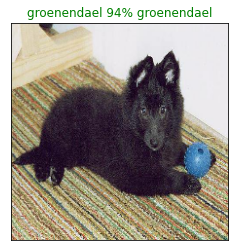

In [172]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77
           )


Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions

This function will:
* Take an input of prediction probabilities array and ground truth array and an integer.

* Find the prediction using`get_pred_label()
* Finde the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green
    
    

In [175]:
predictions[0]

array([2.07927311e-03, 3.86853535e-05, 3.43932491e-03, 5.06465040e-05,
       1.71817956e-04, 2.00590584e-05, 7.15443911e-03, 2.39129164e-04,
       2.44770403e-04, 2.28464967e-04, 7.41420881e-05, 5.49935139e-05,
       8.13909501e-05, 6.87595311e-05, 8.88084585e-04, 1.61044169e-04,
       1.96544861e-04, 1.64106831e-01, 1.81161304e-05, 5.51192134e-05,
       2.82970752e-04, 1.43848301e-04, 2.49326149e-05, 5.95270772e-04,
       1.08809720e-04, 1.11024608e-04, 6.12990595e-02, 1.62197859e-04,
       9.73551869e-05, 4.54333465e-04, 8.99256484e-05, 3.45693482e-03,
       1.48406121e-04, 5.68948672e-05, 1.22940037e-04, 3.17774601e-02,
       6.22625012e-05, 1.16482133e-03, 8.18706540e-05, 5.14852982e-05,
       8.50068347e-04, 7.52988399e-06, 1.00695383e-04, 9.83432168e-04,
       3.51137555e-06, 5.06665056e-05, 2.29496000e-05, 1.93234111e-04,
       3.82597005e-04, 1.36543458e-04, 9.45848587e-05, 5.68510986e-05,
       3.20407125e-05, 5.33779494e-05, 1.95167988e-04, 2.13711013e-04,
      

In [178]:
# toamos los 10 mas elevados ( los ultimo 10 )
# la forma correcta de entender este slicing  es que va desde -10 hasta -1
predictions[0].argsort()[-10:][::-1]
# esto nos da el orden de los indeces para organizar el array, de forma ascente, quiere decir
# que el ultimo  elemento de  la lista sera el mayor, al invertirlo, el elemento mayor queda de primero
 # esto me devuelve el top 10 de los indices donde ocurren los valores mas altos de la probabilida en orden descendente

array([ 17,  59, 109,  70,  73,  83,  26, 102,  79,  35], dtype=int64)

In [182]:
unique_breeds[predictions[0].argsort()[-10:][::-1]]

array(['border_terrier', 'irish_wolfhound', 'tibetan_terrier', 'lhasa',
       'maltese_dog', 'otterhound', 'cairn', 'silky_terrier',
       'norfolk_terrier', 'dandie_dinmont'], dtype=object)

In [179]:
# al pasarle los 10 indices, obtenemos los 10 probabilidades mas altas
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.16410683, 0.14008163, 0.12938438, 0.09278733, 0.07508957,
       0.06849624, 0.06129906, 0.05079208, 0.03792061, 0.03177746],
      dtype=float32)

In [180]:
predictions[0].max()

0.16410683

In [189]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plot the top 10 highest prediction confidences along with the truth label
    for sample n.
    """
    
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    # Get the predicted label
    pred_label = get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color="gray")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    
    # Change  color of true label
    # si la verdadera esta en la lista de probabilidades pintamos de verde
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass
        
    

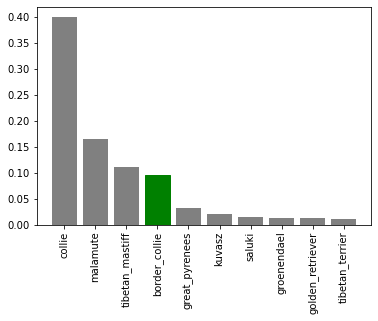

In [190]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictons and evaluate our model
let's check out a few.

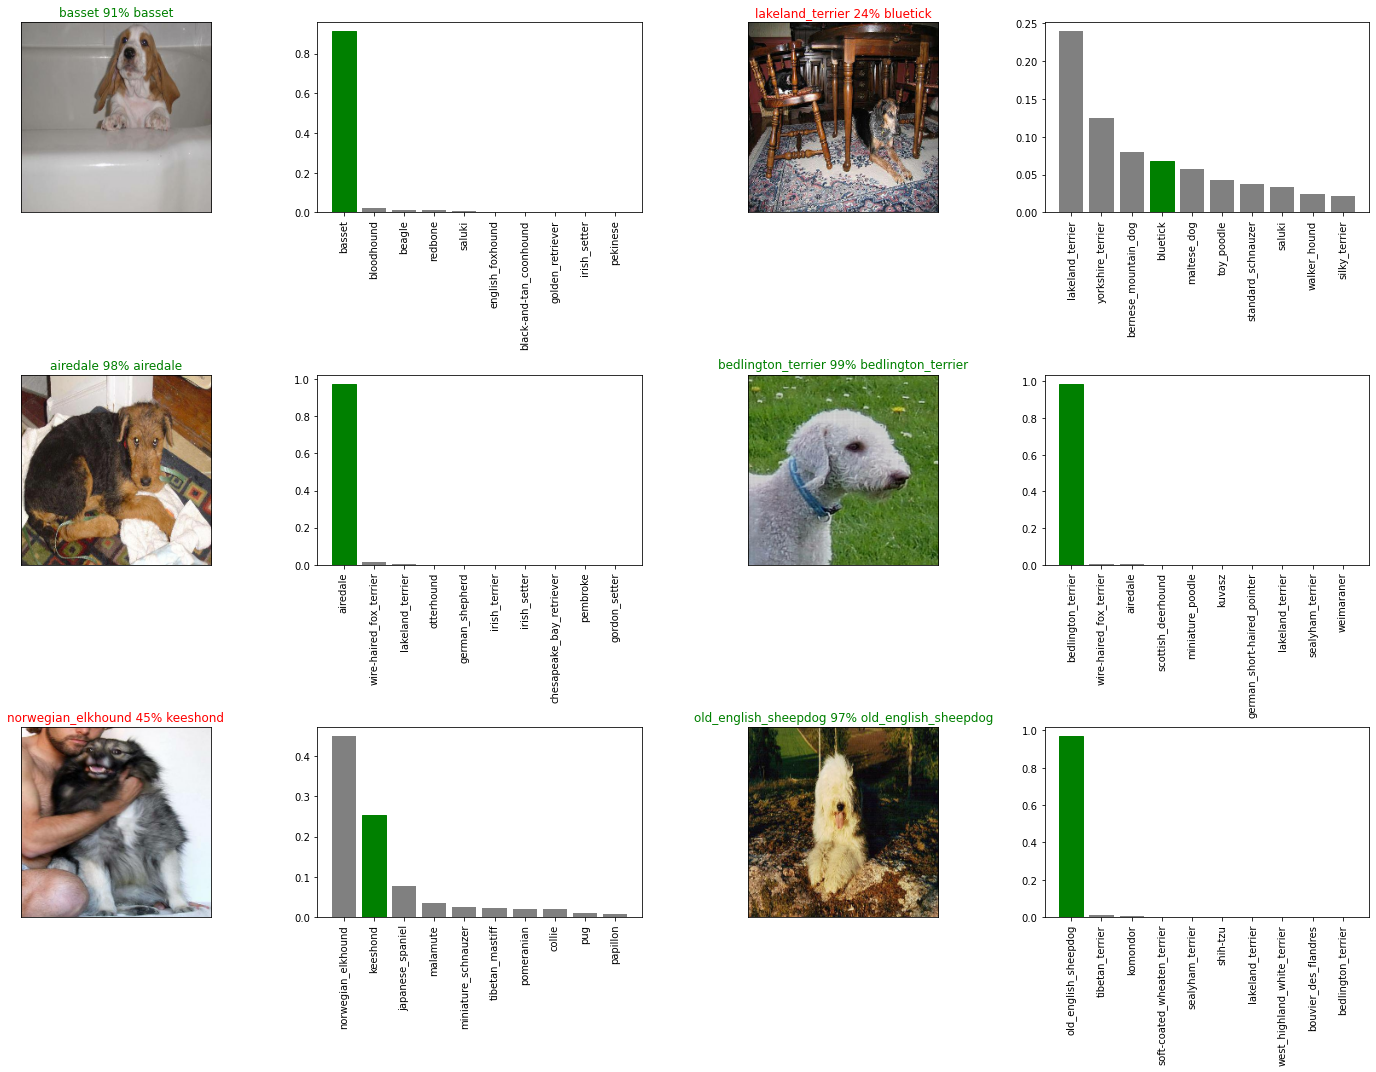

In [204]:
# Let's chek out a few predictions and ther different values
i_multiplier = 2

num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize = (10*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2 * i + 1)
    plot_pred(prediction_probabilities=predictions,
             labels=val_labels,
             images = val_images,
             n = i+i_multiplier)
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities = predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()
    

**Challange:** How would you create a confusion matrix with our models predictions and true labels

## Saving and reloading a model a trained model

In [215]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix(string).
    
    
    
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("dog-breed-identification/models",
                             datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
                            
    model_path = modeldir + "-" + suffix + ".h5"# save format of model
    print(f"Saving model to: {model_path}....")
    model.save(model_path)
    return model_path

In [221]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    
    """
    print(f"Loading saved model from: {model_path}")
    
    # el segundo argumento es praa indicar que tenemos una capa especial(el model importado)
    model = tf.keras.models.load_model(model_path,
                                       custom_objects={"KerasLayer":hub.KerasLayer})
    
    return model

Now we've got functions to save and load a trained model,
let's make sure the work!

In [222]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilnetv2-Adam")

Saving model to: dog-breed-identification/models\20210403-072246-1000-images-mobilnetv2-Adam.h5....


'dog-breed-identification/models\\20210403-072246-1000-images-mobilnetv2-Adam.h5'

In [223]:
# Load a trainet model
loaded_1000_image_model = load_model("dog-breed-identification/models\\20210403-071521-1000-images-mobilnetv2-Adam.h5")

Loading saved model from: dog-breed-identification/models\20210403-071521-1000-images-mobilnetv2-Adam.h5


In [224]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 11s 2s/step - loss: 1.2100 - accuracy: 0.6450


[1.21002995967865, 0.6449999809265137]

In [225]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 12s 2s/step - loss: 1.2100 - accuracy: 0.6450


[1.21002995967865, 0.6449999809265137]

In [226]:
## Training a big dog model (on the full data)
len(X), len(y)

(10222, 10222)

In [227]:
X[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [228]:
X_train[:10]


['dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
 'dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
 'dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
 'dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
 'dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg',
 'dog-breed-identification/train/0ea5759640f2e1c2d1a06adaf8a54ca7.jpg',
 'dog-breed-identification/train/03e1d2ee5fd90aef036c90a9e7f81177.jpg',
 'dog-breed-identification/train/16941a6728ddb9cb7423a6cc97fbe071.jpg',
 'dog-breed-identification/train/0bedbecd92390ef9f4f7c8b06a629340.jpg',
 'dog-breed-identification/train/143b9484273e57668d03bfc26755810a.jpg']

In [229]:
len(X_train)

800

In [230]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [231]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches....


In [232]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [233]:
# Create a model for full model

full_model = create_model()


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [234]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while(maybe up to 30 minutes for the firt epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [235]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 542s 2s/step - loss: 2.3564 - accuracy: 0.4946
Epoch 2/100
320/320 [==============================] - 483s 2s/step - loss: 0.3890 - accuracy: 0.8883
Epoch 3/100
320/320 [==============================] - 483s 2s/step - loss: 0.2288 - accuracy: 0.9418
Epoch 4/100
320/320 [==============================] - 481s 2s/step - loss: 0.1478 - accuracy: 0.9657
Epoch 5/100
320/320 [==============================] - 481s 2s/step - loss: 0.1012 - accuracy: 0.9810
Epoch 6/100
320/320 [==============================] - 485s 2s/step - loss: 0.0730 - accuracy: 0.9876
Epoch 7/100
320/320 [==============================] - 482s 2s/step - loss: 0.0564 - accuracy: 0.9916
Epoch 8/100
320/320 [==============================] - 483s 2s/step - loss: 0.0439 - accuracy: 0.9951
Epoch 9/100
320/320 [==============================] - 474s 1s/step - loss: 0.0352 - accuracy: 0.9965
Epoch 10/100
320/320 [==============================] - 474s 1s/step - loss: 0.027

In [236]:
# conviene siempre salvar luego de entrenar
save_model(full_model, suffix ="full-image-set-mobilnetv2-Adam")

Saving model to: dog-breed-identification/models\20210403-103536-full-image-set-mobilnetv2-Adam.h5....


'dog-breed-identification/models\\20210403-103536-full-image-set-mobilnetv2-Adam.h5'

In [237]:
# Load in the full model, si salen alarmas ignorales
loaded_full_model = load_model("dog-breed-identification/models\\20210403-103536-full-image-set-mobilnetv2-Adam.h5")

Loading saved model from: dog-breed-identification/models\20210403-103536-full-image-set-mobilnetv2-Adam.h5


In [239]:
len(X)

10222

  nota : El multi class log  loss son las proabilidades para cada etiqueta

## Making prediction on the test data set

Since our model has been trained on images in the form of Tensor batches, to make
predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list
of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames(comprehension de listas)
* Convert the filenames into test data batches using`create_data_batches()` and setting the `test_data` parameter to `True`(since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` Method called on  our model.



In [242]:
# Load test image filenames
test_path ="dog-breed-identification/test/"
# lista comprimida
# hey python dame todos los filenames en esta carpeta
test_filenames =[test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [243]:
len(test_filenames)

10357

In [244]:
# Create test data batch
# convierte los arhivos en tensores
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches....


In [245]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on test data batch using the loaded full model will take long time to run.(about an -1hr with gpu).

In [246]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                            
                                             verbose=1)

324/324 [==============================] - 520s 2s/step


In [247]:
# Save predictions (NumPy array) to csv file(for access later)
np.savetxt("dog-breed-identification/preds_array.csv", test_predictions, delimiter=",")

In [249]:
# Load predictions (NumPY array) from csv file
test_predictions = np.loadtxt("dog-breed-identification/preds_array.csv", delimiter=",")

In [250]:
test_predictions[:10]

array([[2.18143537e-12, 1.54180867e-12, 6.95072822e-15, ...,
        1.97817582e-14, 6.81623855e-11, 4.06904198e-12],
       [1.55730652e-06, 1.37589200e-06, 1.86429094e-08, ...,
        2.44809849e-11, 1.54946619e-07, 2.41897502e-09],
       [4.21339907e-11, 5.18097158e-06, 5.34124656e-09, ...,
        1.27025174e-07, 1.81988896e-10, 4.67345156e-11],
       ...,
       [2.20023466e-09, 2.85961393e-10, 4.29478467e-11, ...,
        3.13557448e-12, 4.64667324e-12, 7.71555111e-11],
       [1.03694059e-11, 1.52891511e-09, 1.29514233e-10, ...,
        9.94713901e-07, 1.10709941e-09, 2.99197750e-11],
       [1.99795380e-09, 4.08599508e-11, 2.31930100e-11, ...,
        1.30454762e-12, 1.42629034e-11, 3.03744301e-08]])

In [251]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probablity outputs in a DataFrame with an id a column for 
each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Ad data to the ID column by extracting the test_image ID's from their filepaths.
* Add data ( the prediction probabilities) to each of dog breed columns

* Export the DataFrame as CSV to submit it to Kaggle.

In [252]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [253]:
["id"] + list(unique_breeds)

['id',
 'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenen

In [254]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [255]:
test_filenames

['dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg',
 'dog-breed-identification/test/0041940322116ae58c38130f5a6f71f9.jpg',
 'dog-breed-identification/test/0042d6bf3e5f3700865886db32689436.jpg',
 'dog-breed-identification/test/004476c96f575879af4af471af65cae8.jpg',
 'dog-breed-identification/test/00485d47de966a9437ad3b33ac193b6f.jpg',
 'dog-

In [256]:
# Append test image ID's to predictions DataFrame
test_path

'dog-breed-identification/test/'

In [262]:
# en este caso no queremos la extension por eso tomamnos la primera pocision nada mas
test_ids =[os.path.splitext(path)[0]for path in os.listdir(test_path)]

In [263]:
os.path.splitext(test_filenames[0])

('dog-breed-identification/test/000621fb3cbb32d8935728e48679680e', '.jpg')

In [264]:
test_ids

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e',
 '00225dcd3e4d2410dd53239f95c0352f',
 '002c2a3117c2193b4d26400ce431eebd',
 '002c58d413a521ae8d1a5daeb35fc803',
 '002f80396f1e3db687c5932d7978b196',
 '0036c6bcec6031be9e62a257b1c3c442',
 '0041940322116ae58c38130f5a6f71f9',
 '0042d6bf3e5f3700865886db32689436',
 '004476c96f575879af4af471af65cae8',
 '00485d47de966a9437ad3b33ac193b6f',
 '00496f65de6cc319145ce97bd6e90360',
 '004bf14426d1a830d459a9e0c0721309',
 '004c3721eb88358f462cdcec6b2380b7',
 '00559f56aab7e0a7749220f6aed65162',
 '005b281f1a4d6f29d527c9585e9bd33c',
 '005b6c6c76fefd6b458ef6fb6e54da6e',
 '006870b49353779b25eeb91fed43c31a',
 '0068f3a21b159ece126a28580cdad7a0',
 '0069b1cc4546fc98f84f981bf9a0696a',
 '0077bc3c63486ff09d3774d956af8f76',
 '00780e5d2bf4f7e4b5f96d08ddde669a',
 '007ed71136966728f5c0936e23c8286b',
 '0081831ceb49cd64212c32b884036b82',
 

In [265]:
preds_df["id"]= test_ids

In [266]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
# estamos haciendo un sub-array o una intercepcion de conjuntos
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.18144e-12,1.54181e-12,6.95073e-15,2.27057e-14,1.11073e-13,1.88274e-12,6.52895e-17,4.88184e-14,5.70171e-14,...,1.9495e-13,2.08595e-14,2.96513e-15,8.11417e-16,1.93276e-15,1.29855e-13,1.85159e-14,1.97818e-14,6.81624e-11,4.06904e-12
1,00102ee9d8eb90812350685311fe5890,1.55731e-06,1.37589e-06,1.86429e-08,5.09529e-09,1.96984e-07,1.26435e-08,1.53759e-06,6.30618e-07,6.58169e-09,...,8.70879e-09,5.04947e-07,4.00212e-09,2.66059e-06,5.65753e-08,5.93542e-08,0.000443523,2.4481e-11,1.54947e-07,2.41898e-09
2,0012a730dfa437f5f3613fb75efcd4ce,4.2134e-11,5.18097e-06,5.34125e-09,1.48077e-10,2.71471e-10,1.84498e-08,3.36574e-11,6.37042e-12,7.49606e-09,...,1.58145e-11,8.404e-12,5.41399e-07,1.43029e-06,6.76919e-08,3.80947e-08,3.53191e-12,1.27025e-07,1.81989e-10,4.67345e-11
3,001510bc8570bbeee98c8d80c8a95ec1,9.02868e-07,4.61483e-07,5.12572e-07,3.91944e-07,2.52801e-05,1.51322e-06,3.45177e-11,2.92388e-08,5.43171e-08,...,1.59135e-06,6.83461e-11,5.29761e-05,2.48418e-09,1.70668e-07,3.17319e-09,5.59988e-15,0.000984569,7.59921e-11,1.81952e-08
4,001a5f3114548acdefa3d4da05474c2e,3.48377e-05,9.90314e-06,4.42039e-09,1.29297e-09,1.32594e-09,1.49867e-11,5.56837e-10,6.03989e-09,2.78249e-09,...,2.15933e-07,1.0249e-10,1.32877e-10,1.14348e-10,2.78089e-10,3.07657e-10,2.20886e-11,5.71022e-09,8.58857e-10,9.48017e-09


In [268]:
# Save our predicitions dataframes to CSV for submission to Kaggle
preds_df.to_csv("dog-breed-identification/full_model_predictions_submission_1_mobilnetV2.csv",
               
                index=False)

## Making predicitions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data bataches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data parameter to True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.


In [270]:
# Get custom images filepaths
custom_path ="dog-breed-identification/my-dog-photos/"

custom_image_paths =[custom_path + fname for fname in os.listdir(custom_path)]

In [271]:
custom_image_paths

['dog-breed-identification/my-dog-photos/dog-photo-1.jpeg',
 'dog-breed-identification/my-dog-photos/dog-photo-2.jpeg',
 'dog-breed-identification/my-dog-photos/dog-photo-3.jpeg']

In [272]:
# Turn custom images into batch datasets

# como no tiene labels ponemos test_data = True
custom_data = create_data_batches(custom_image_paths,
                                  test_data=True)

custom_data

Creating test data batches....


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [273]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [276]:
custom_preds.shape

(3, 120)

In [277]:
# Get custom image prediction labels
custom_pred_labels =[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['golden_retriever', 'lakeland_terrier', 'labrador_retriever']

In [278]:
# Get custom images(our unbatchify()) function won't work since there aren't label..., maybe we could fix this later
custom_images = []


# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)
    

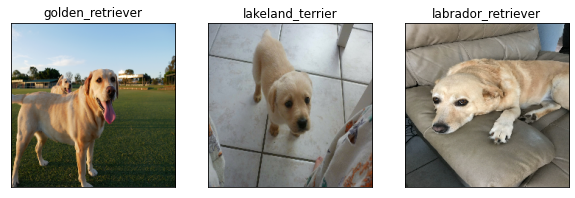

In [279]:
# Check custom image predictions
plt.figure(figsize=(10,10))

# el enumerador  cuanta(empieza en 0) y me regresa una suma de elementos en cada iteracion mas el valor de la lista
for i, image in enumerate(custom_images):
    plt.subplot(1, 3, i+1)
    # con esto quitamos la escala
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)